## Surrogate-Based Operability Analysis of a Membrane Reactor

Author: Rafael Heilbuth, Federal University of Uberlândia (PhD Student)

This notebook demonstrates how surrogate models (here, **Gaussian Process (GP)** regression) can replace computationally expensive first-principles models for process operability analysis.

Operability calculations require many model evaluations. Particularly **inverse mapping**, which solves numerous optimization problems to find designs achieving a desired output specification. When each model evaluation is computationally expensive, a validated surrogate enables rapid exploration of different DOS specifications or constraint scenarios.

We use the **Direct Methane Aromatization Membrane Reactor (DMA-MR)** as our case study, inspired by {cite}`alves2022gp`.

For details on the first-principles model equations, see the [Membrane Reactor example](membrane_reactor.ipynb) in this gallery.

**Variables:**

| Input (AIS) | Output (AOS) |
|---|---|
| Tube Length [cm] | Benzene Production [mg/h] |
| Tube Diameter [cm] | Methane Conversion [%] |

### First-Principles Model

We first define the rigorous DMA-MR model that serves as our "ground truth" for generating training data. The model integrates a system of ODEs representing mole balances in a shell-and-tube membrane reactor.

With the stage set, let's start by importing some JAX modules since we will be building an automatic differentiation-based process model.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import jax.numpy as jnp
from jax.numpy import pi
from jax.experimental.ode import odeint
from jax import config, jit
config.update("jax_enable_x64", True)

import numpy as np
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import time

The model requires kinetic parameters, experiment conditions, and the ODE system for the mole balances. The `dma_mr_design` function maps design inputs (tube length and diameter) to process outputs (benzene production and methane conversion).

In [2]:
# Kinetic and experiment parameters
R = 8.314e6                 # [Pa.cm³/(K.mol.)]
k1 = 0.04                   # [s⁻¹]
k1_Inv = 6.40e6             # [cm³/s-mol]
k2 = 4.20                   # [s⁻¹]
k2_Inv = 56.38              # [cm³/s-mol]
MM_B = 78.00                # Benzene molecular weight [g/mol]

T = 1173.15                 # Temperature [K] = 900 [°C] (Isothermal)
Q = 3600 * 0.01e-4          # [mol/(h.cm².atm^1/4)]
selec = 1500

# Tube side
Pt = 101325.0               # Pressure [Pa] (1 atm)
v0 = 3600 * (2 / 15)        # Vol. Flowrate [cm³/h]
Ft0 = Pt * v0 / (R * T)     # Initial molar flowrate [mol/h] - Pure CH4

# Shell side
Ps = 101325.0               # Pressure [Pa] (1 atm)
v_He = 3600 * (1 / 6)       # Vol. flowrate [cm³/h]
F_He = Ps * v_He / (R * T)  # Sweep gas molar flowrate [mol/h]


def dma_mr_model(F, z, dt, v_He, v0, F_He, Ft0):
    """ODE system for the DMA-MR mole balances."""
    At = 0.25 * jnp.pi * (dt ** 2)
    F = jnp.where(F <= 1e-9, 1e-9, F)

    Ft = F[0:4].sum()
    Fs = F[4:].sum() + F_He
    v = v0 * (Ft / Ft0)
    C = F[:4] / v

    P0t = (Pt / 101325) * (F[0] / Ft)
    P1t = (Pt / 101325) * (F[1] / Ft)
    P2t = (Pt / 101325) * (F[2] / Ft)
    P3t = (Pt / 101325) * (F[3] / Ft)
    P0s = (Ps / 101325) * (F[4] / Fs)
    P1s = (Ps / 101325) * (F[5] / Fs)
    P2s = (Ps / 101325) * (F[6] / Fs)
    P3s = (Ps / 101325) * (F[7] / Fs)

    r0 = 3600 * k1 * C[0] * (1 - ((k1_Inv * C[1] * C[2] ** 2) / (k1 * (C[0])**2)))
    r0 = jnp.where(C[0] <= 1e-9, 0, r0)
    r1 = 3600 * k2 * C[1] * (1 - ((k2_Inv * C[3] * C[2] ** 3) / (k2 * (C[1])**3)))
    r1 = jnp.where(C[1] <= 1e-9, 0, r1)

    eff = 0.9
    vb = 0.5
    Cat = (1 - vb) * eff

    dF0 = -Cat * r0 * At - (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF1 = 0.5 * Cat * r0 * At - Cat * r1 * At - (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF2 = Cat * r0 * At + Cat * r1 * At - Q * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF3 = (1/3) * Cat * r1 * At - (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    dF4 = (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF5 = (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF6 = Q * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF7 = (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt

    return jnp.array([dF0, dF1, dF2, dF3, dF4, dF5, dF6, dF7])


def dma_mr_design(u):
    """First-principles model: maps design inputs to outputs.

    Args:
        u: [Tube Length (cm), Tube Diameter (cm)]

    Returns:
        [Benzene Production (mg/h), Methane Conversion (%)]
    """
    L, dt = u[0], u[1]
    y0 = jnp.hstack((Ft0, jnp.zeros(7)))
    z = jnp.linspace(0, L, 2000)
    F = odeint(dma_mr_model, y0, z, dt, v_He, v0, F_He, Ft0, rtol=1e-10, atol=1e-10)

    F_C6H6 = (F[-1, 3] * 1000) * MM_B   # Benzene production [mg/h]
    X_CH4 = 100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0  # Methane conversion [%]
    return jnp.array([F_C6H6, X_CH4])


# Verify model works
test_output = dma_mr_design(jnp.array([100.0, 1.0]))
print(f"Test point (L=100 cm, D=1 cm):")
print(f"  Benzene Production: {test_output[0]:.2f} mg/h")
print(f"  Methane Conversion: {test_output[1]:.2f} %")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Test point (L=100 cm, D=1 cm):
  Benzene Production: 14.74 mg/h
  Methane Conversion: 42.12 %


### Training Data Generation

To train a surrogate, we need input-output data from the first-principles model. We use **Latin Hypercube Sampling (LHS)** to efficiently cover the input space with 2000 samples.

| Variable | Lower Bound | Upper Bound |
|---|---|---|
| Tube Length [cm] | 10 | 300 |
| Tube Diameter [cm] | 0.1 | 2 |

In [3]:
# Define AIS bounds and generate LHS samples
L_bounds = [10, 300]
D_bounds = [0.1, 2]
n_samples = 2000

sampler = qmc.LatinHypercube(d=2, seed=42)
samples_unit = sampler.random(n=n_samples)
X_samples = qmc.scale(samples_unit, [L_bounds[0], D_bounds[0]], [L_bounds[1], D_bounds[1]])

print(f"Generated {n_samples} LHS samples")
print(f"  Length range: [{X_samples[:,0].min():.1f}, {X_samples[:,0].max():.1f}] cm")
print(f"  Diameter range: [{X_samples[:,1].min():.2f}, {X_samples[:,1].max():.2f}] cm")

Generated 2000 LHS samples
  Length range: [10.0, 300.0] cm
  Diameter range: [0.10, 2.00] cm


We evaluate the first-principles model at each sample point and split into training and test sets.

In [4]:
# Evaluate first-principles model on all samples
print("Generating training data from first-principles model...")
start_time = time.time()

Y_samples = np.zeros((n_samples, 2))
for i in range(n_samples):
    Y_samples[i, :] = np.array(dma_mr_design(jnp.array(X_samples[i, :])))
    if (i + 1) % 500 == 0:
        print(f"  Completed {i+1}/{n_samples} samples...")

print(f"\nData generation completed in {time.time() - start_time:.1f} seconds")

# Train/Test split (1800 train, 200 test)
np.random.seed(42)
indices = np.random.permutation(n_samples)
n_train = 1800

X_train, X_test = X_samples[indices[:n_train]], X_samples[indices[n_train:]]
Y_train, Y_test = Y_samples[indices[:n_train]], Y_samples[indices[n_train:]]

print(f"Training set: {n_train} samples")
print(f"Test set: {n_samples - n_train} samples")

Generating training data from first-principles model...
  Completed 500/2000 samples...
  Completed 1000/2000 samples...
  Completed 1500/2000 samples...
  Completed 2000/2000 samples...

Data generation completed in 52.4 seconds
Training set: 1800 samples
Test set: 200 samples


### GP Model Training & Validation

We train separate GP models for each output using scikit-learn. Inputs are standardized (Z-score) and we use a small regularization parameter since the training data is noise-free.

In [5]:
# Standardize inputs
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Train GP models
kernel = ConstantKernel(1.0) * RBF(length_scale=[1.0, 1.0])

gpr_benzene = GaussianProcessRegressor(
    kernel=kernel, alpha=1e-8, n_restarts_optimizer=5, random_state=42, normalize_y=True
)
gpr_benzene.fit(X_train_scaled, Y_train[:, 0])

gpr_conversion = GaussianProcessRegressor(
    kernel=kernel, alpha=1e-8, n_restarts_optimizer=5, random_state=42, normalize_y=True
)
gpr_conversion.fit(X_train_scaled, Y_train[:, 1])

# Validate on test set
Y_pred_benzene = gpr_benzene.predict(X_test_scaled)
Y_pred_conversion = gpr_conversion.predict(X_test_scaled)

print("Validation Results (Hold-out Test Set):")
print(f"  Benzene Production:  R² = {r2_score(Y_test[:, 0], Y_pred_benzene):.6f}, "
      f"RMSE = {np.sqrt(mean_squared_error(Y_test[:, 0], Y_pred_benzene)):.4f} mg/h")
print(f"  Methane Conversion:  R² = {r2_score(Y_test[:, 1], Y_pred_conversion):.6f}, "
      f"RMSE = {np.sqrt(mean_squared_error(Y_test[:, 1], Y_pred_conversion)):.4f} %")

Validation Results (Hold-out Test Set):
  Benzene Production:  R² = 1.000000, RMSE = 0.0019 mg/h
  Methane Conversion:  R² = 1.000000, RMSE = 0.0025 %


### JAX Wrapper for Surrogate Model

To use `ad=True` in opyrability's NLP solver, we wrap the GP in a JAX-compatible function for automatic differentiation.

In [6]:
# Extract GP parameters for JAX
muX, sdX = jnp.array(scaler_X.mean_), jnp.array(scaler_X.scale_)

alpha_benz = jnp.array(gpr_benzene.alpha_)
X_train_benz = jnp.array(gpr_benzene.X_train_)
y_mean_benz, y_std_benz = jnp.array(gpr_benzene._y_train_mean), jnp.array(gpr_benzene._y_train_std)
const_benz = jnp.array(gpr_benzene.kernel_.k1.constant_value)
length_scale_benz = jnp.array(gpr_benzene.kernel_.k2.length_scale)

alpha_conv = jnp.array(gpr_conversion.alpha_)
X_train_conv = jnp.array(gpr_conversion.X_train_)
y_mean_conv, y_std_conv = jnp.array(gpr_conversion._y_train_mean), jnp.array(gpr_conversion._y_train_std)
const_conv = jnp.array(gpr_conversion.kernel_.k1.constant_value)
length_scale_conv = jnp.array(gpr_conversion.kernel_.k2.length_scale)

@jit
def surrogate_jit(u):
    """JIT-compiled JAX surrogate replicating sklearn GP prediction."""
    u_flat = u.reshape(-1)
    x_scaled = (u_flat - muX) / sdX

    diff_benz = X_train_benz - x_scaled
    k_benz = const_benz * jnp.exp(-0.5 * jnp.sum((diff_benz / length_scale_benz)**2, axis=1))
    y_benz = jnp.dot(k_benz, alpha_benz) * y_std_benz + y_mean_benz

    diff_conv = X_train_conv - x_scaled
    k_conv = const_conv * jnp.exp(-0.5 * jnp.sum((diff_conv / length_scale_conv)**2, axis=1))
    y_conv = jnp.dot(k_conv, alpha_conv) * y_std_conv + y_mean_conv

    return jnp.array([y_benz, y_conv])

def jax_surrogate(u):
    return surrogate_jit(jnp.array(u))

### Inverse Mapping Comparison

We now perform **NLP-based inverse mapping** to find the design region (DIS*) that achieves a desired output specification.

**Desired Output Set (DOS):**
- Benzene Production: 20–25 mg/h
- Methane Conversion: 35–45%

**Constraint:** The plug-flow assumption requires a minimum length-to-diameter ratio of 30 to ensure negligible axial dispersion ($L/D \geq 30$).

We compare both the surrogate and first-principles models to quantify accuracy and speedup.

Let's import opyrability's inverse mapping (NLP-based) module:

In [7]:
from opyrability import nlp_based_approach

# Define DOS, bounds, and constraints
DOS_bounds = jnp.array([[20, 25],    # Benzene [mg/h]
                        [35, 45]])   # Conversion [%]
DOS_resolution = [10, 10]

lb = jnp.array([10, 0.1])    # Lower bounds for L, D
ub = jnp.array([300, 2])     # Upper bounds for L, D
u0 = jnp.array([50, 1])      # Initial estimate

# Plug-flow constraint: L/D >= 30
def plug_flow(u):
    return u[0] - 30.0 * u[1]

constraint = {'type': 'ineq', 'fun': plug_flow}

**GP Surrogate Inverse Mapping:**

Running inverse mapping with GP Surrogate...
 You have selected automatic differentiation as a method for obtaining higher-order data (Jacobians/Hessian),
 Make sure your process model is JAX-compatible implementation-wise.


  0%|          | 0/100 [00:00<?, ?it/s]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Completed in 64.38 seconds


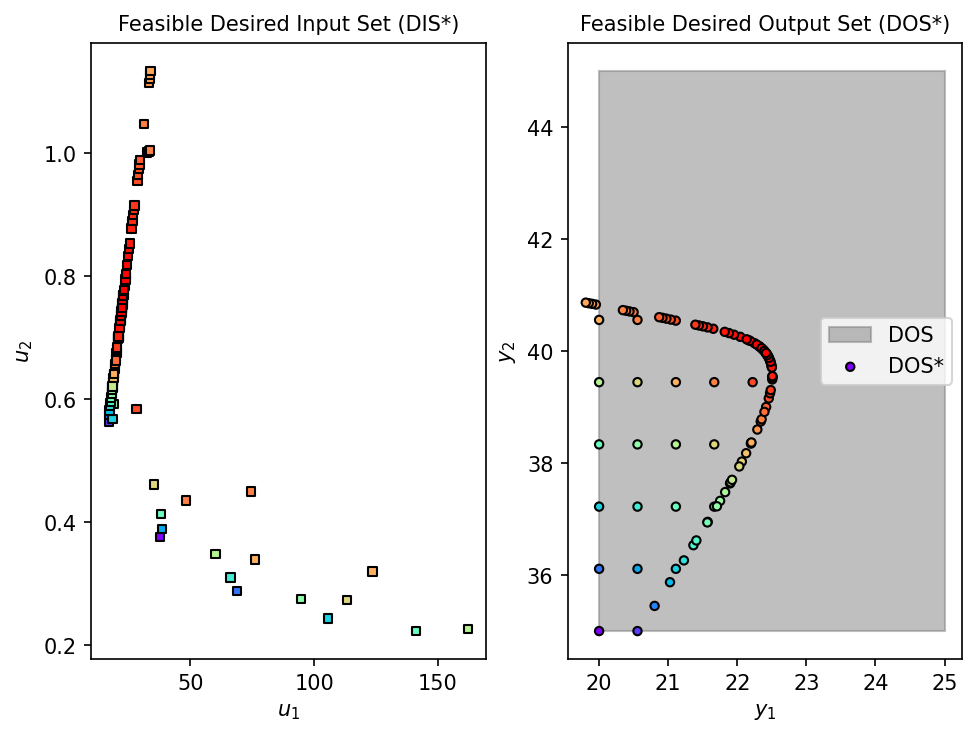

In [8]:
# Inverse mapping with GP Surrogate
print("Running inverse mapping with GP Surrogate...")
start_surrogate = time.time()
fDIS_surr, fDOS_surr, conv_surr = nlp_based_approach(
    jax_surrogate, DOS_bounds, DOS_resolution, u0, lb, ub,
    constr=constraint, method='ipopt', plot=True, ad=True, warmstart=False
)
time_surrogate = time.time() - start_surrogate
print(f"Completed in {time_surrogate:.2f} seconds")

**First-Principles Model Inverse Mapping:**

Running inverse mapping with First-Principles Model...
 You have selected automatic differentiation as a method for obtaining higher-order data (Jacobians/Hessian),
 Make sure your process model is JAX-compatible implementation-wise.


100%|██████████| 100/100 [04:11<00:00,  2.51s/it]


Completed in 251.34 seconds


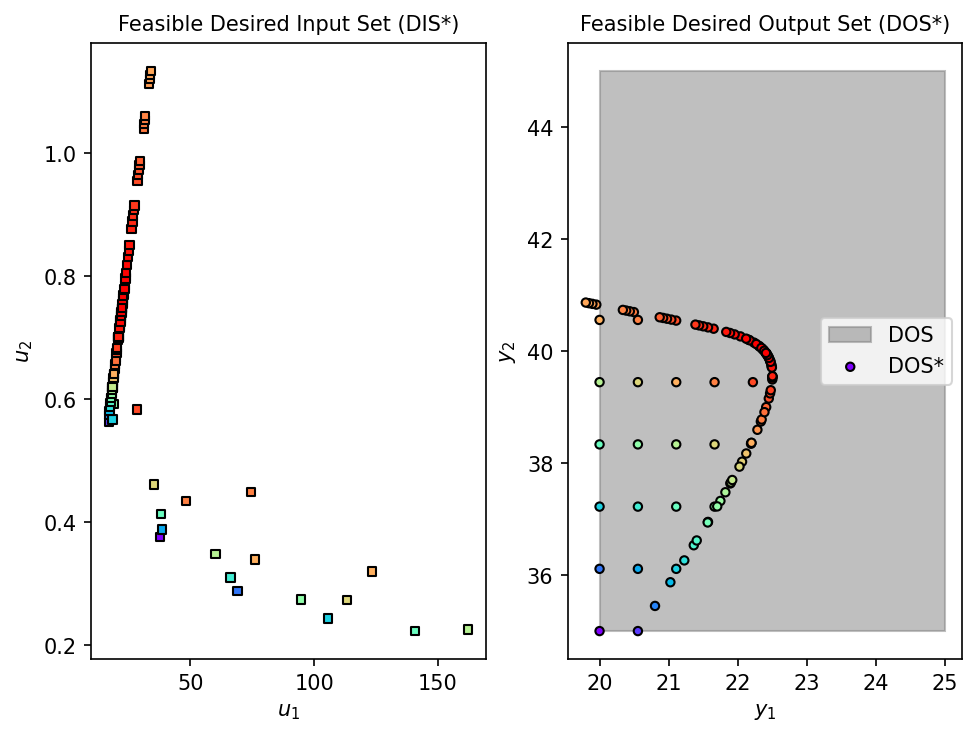

In [9]:
# Inverse mapping with First-Principles Model
print("Running inverse mapping with First-Principles Model...")
start_fp = time.time()
fDIS_fp, fDOS_fp, conv_fp = nlp_based_approach(
    dma_mr_design, DOS_bounds, DOS_resolution, u0, lb, ub,
    constr=constraint, method='ipopt', plot=True, ad=True, warmstart=False
)
time_fp = time.time() - start_fp
print(f"Completed in {time_fp:.2f} seconds")

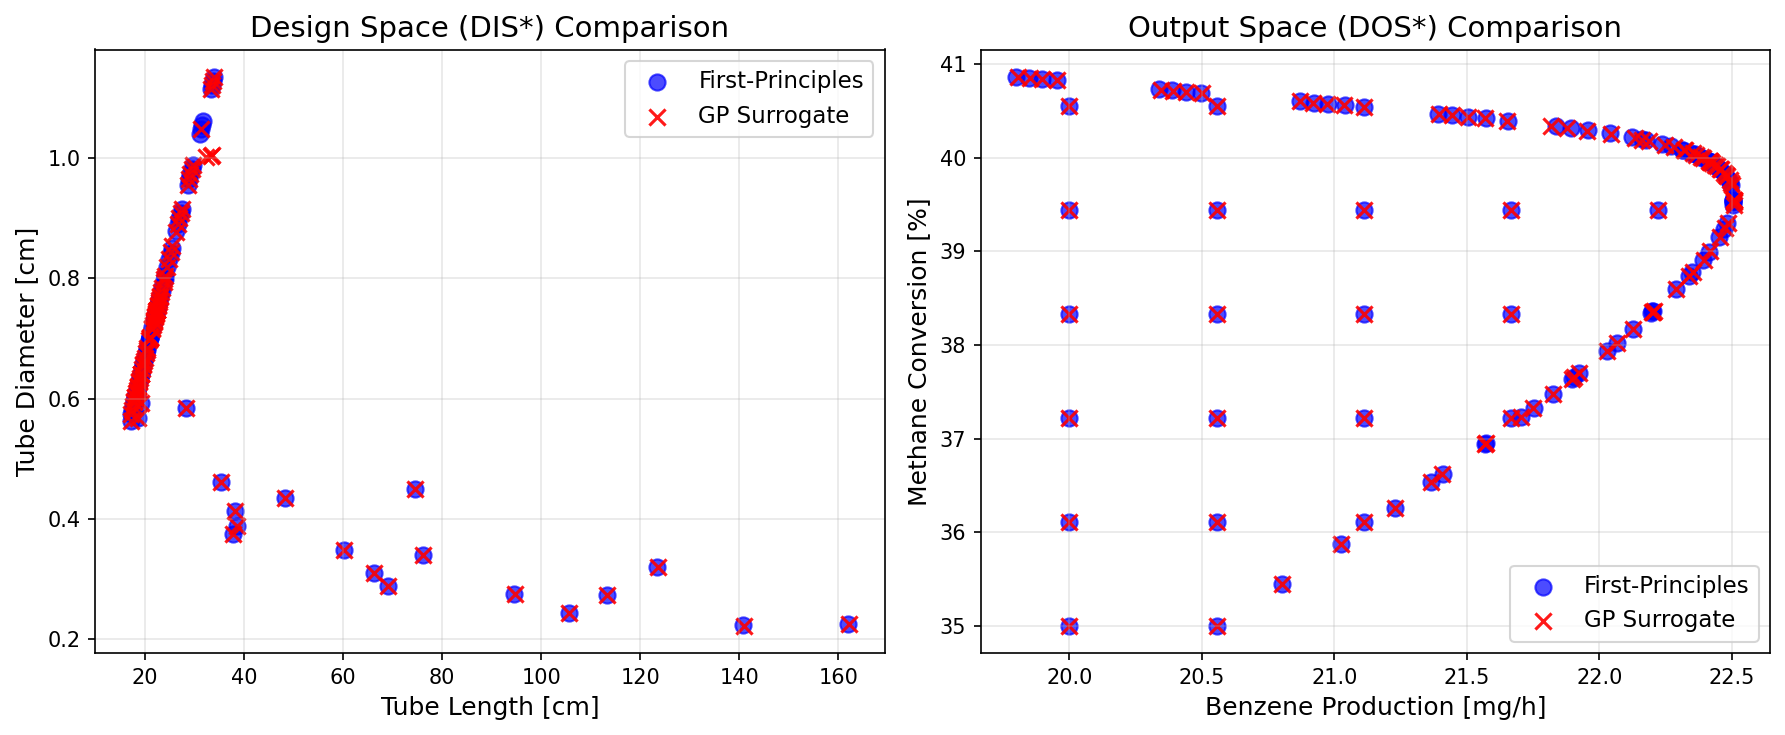

In [10]:
# Overlay plot: Visual comparison of DIS* and DOS* from both approaches
dis_fp = np.array([u for u in fDIS_fp if u is not None])
dis_surr = np.array([u for u in fDIS_surr if u is not None])
dos_fp = np.array([y for y in fDOS_fp if y is not None])
dos_surr = np.array([y for y in fDOS_surr if y is not None])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# DIS* overlay
axes[0].scatter(dis_fp[:, 0], dis_fp[:, 1], c='blue', s=60, alpha=0.7, label='First-Principles')
axes[0].scatter(dis_surr[:, 0], dis_surr[:, 1], c='red', marker='x', s=60, alpha=0.9, label='GP Surrogate')
axes[0].set_xlabel('Tube Length [cm]', fontsize=12)
axes[0].set_ylabel('Tube Diameter [cm]', fontsize=12)
axes[0].set_title('Design Space (DIS*) Comparison', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# DOS* overlay
axes[1].scatter(dos_fp[:, 0], dos_fp[:, 1], c='blue', s=60, alpha=0.7, label='First-Principles')
axes[1].scatter(dos_surr[:, 0], dos_surr[:, 1], c='red', marker='x', s=60, alpha=0.9, label='GP Surrogate')
axes[1].set_xlabel('Benzene Production [mg/h]', fontsize=12)
axes[1].set_ylabel('Methane Conversion [%]', fontsize=12)
axes[1].set_title('Output Space (DOS*) Comparison', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Results Comparison

In [11]:
# Calculate mean design values from DIS*
mean_L_surr = np.mean([p[0] for p in fDIS_surr if p is not None])
mean_D_surr = np.mean([p[1] for p in fDIS_surr if p is not None])
mean_L_fp = np.mean([p[0] for p in fDIS_fp if p is not None])
mean_D_fp = np.mean([p[1] for p in fDIS_fp if p is not None])

print("=" * 60)
print("INVERSE MAPPING COMPARISON")
print("=" * 60)
print(f"\nMean Design Values:")
print(f"  {'Variable':<20} {'First-Principles':>18} {'GP':>18} {'Rel. Error':>12}")
print(f"  {'-'*20} {'-'*18} {'-'*18} {'-'*12}")
print(f"  {'Tube Length [cm]':<20} {mean_L_fp:>18.4f} {mean_L_surr:>18.4f} "
      f"{abs(mean_L_fp - mean_L_surr) / mean_L_fp * 100:>11.4f}%")
print(f"  {'Tube Diameter [cm]':<20} {mean_D_fp:>18.4f} {mean_D_surr:>18.4f} "
      f"{abs(mean_D_fp - mean_D_surr) / mean_D_fp * 100:>11.4f}%")

print(f"\nComputational Time:")
print(f"  First-Principles: {time_fp:.2f} seconds")
print(f"  GP Surrogate: {time_surrogate:.2f} seconds")
print(f"  Speedup: {time_fp/time_surrogate:.1f}x faster")

INVERSE MAPPING COMPARISON

Mean Design Values:
  Variable               First-Principles                 GP   Rel. Error
  -------------------- ------------------ ------------------ ------------
  Tube Length [cm]                32.1095            32.1554      0.1430%
  Tube Diameter [cm]               0.6913             0.6896      0.2415%

Computational Time:
  First-Principles: 251.34 seconds
  GP Surrogate: 64.38 seconds
  Speedup: 3.9x faster


### Operability Index Evaluation

Finally, we calculate the **Operability Index (OI)** using multimodel representation. This measures what fraction of the DOS is achievable given the AIS constraints.

Let's import opyrability's multimodel approach and OI evaluation modules:

Computing AOS with GP surrogate...


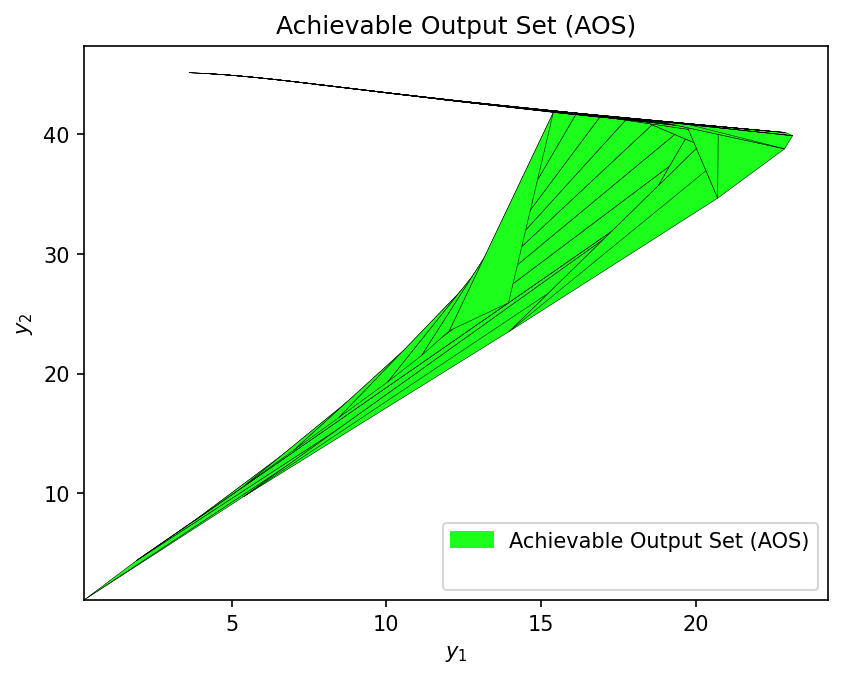

  Completed in 1.51 seconds

Computing AOS with first-principles model...


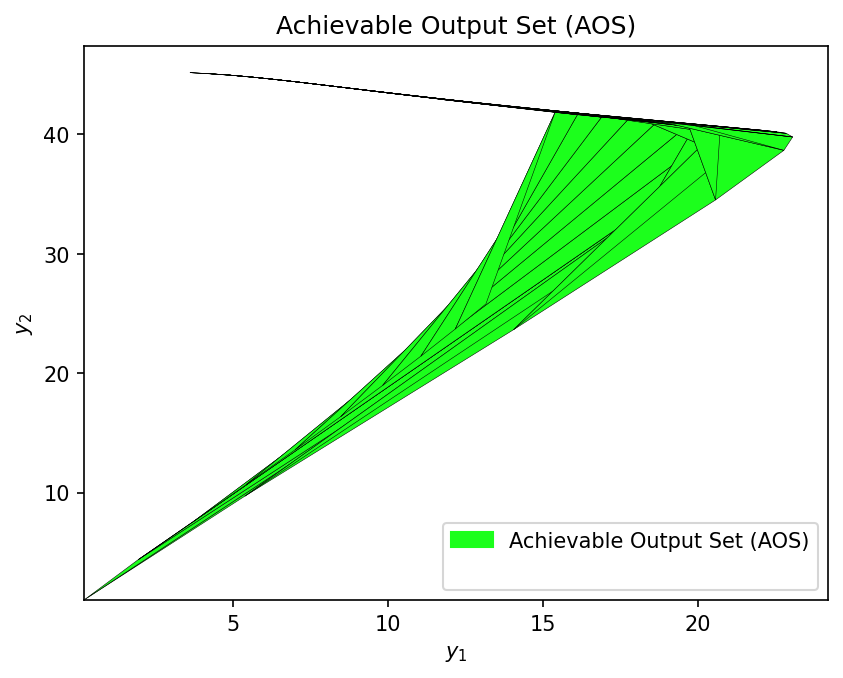

  Completed in 4.15 seconds


In [12]:
from opyrability import multimodel_rep, OI_eval

# Define AIS for multimodel representation
AIS_bounds = jnp.array([[10, 300], [0.1, 2]])
AIS_resolution = [10, 10]

# Compute AOS with both models
print("Computing AOS with GP surrogate...")
start_surr_mm = time.time()
AOS_surr = multimodel_rep(jax_surrogate, AIS_bounds, AIS_resolution)
time_surr_mm = time.time() - start_surr_mm
print(f"  Completed in {time_surr_mm:.2f} seconds")

print("\nComputing AOS with first-principles model...")
start_fp_mm = time.time()
AOS_fp = multimodel_rep(dma_mr_design, AIS_bounds, AIS_resolution)
time_fp_mm = time.time() - start_fp_mm
print(f"  Completed in {time_fp_mm:.2f} seconds")

**First-Principles Model OI:**

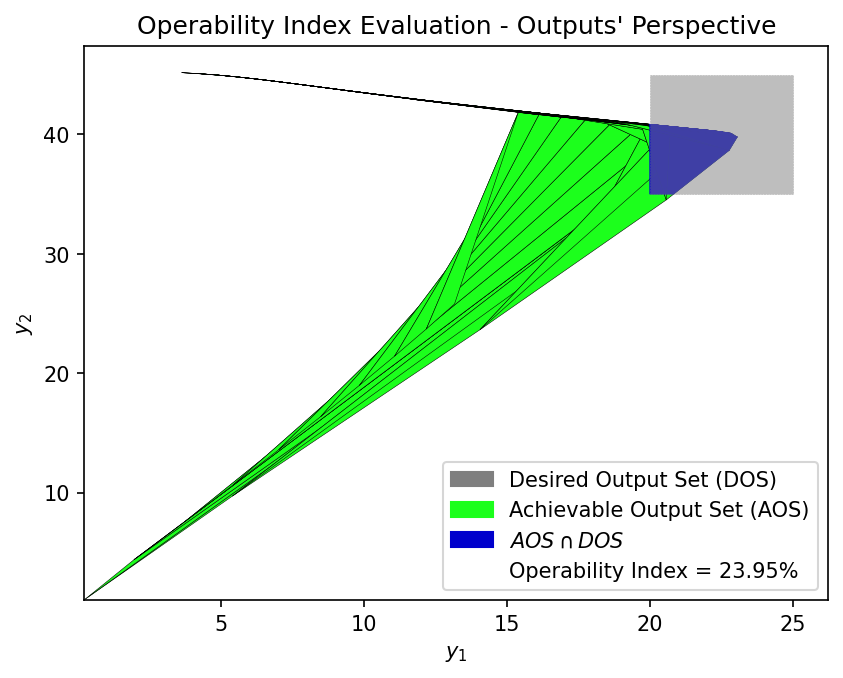

In [13]:
OI_fp = OI_eval(AOS_fp, DOS_bounds, plot=True)

**GP Surrogate OI:**

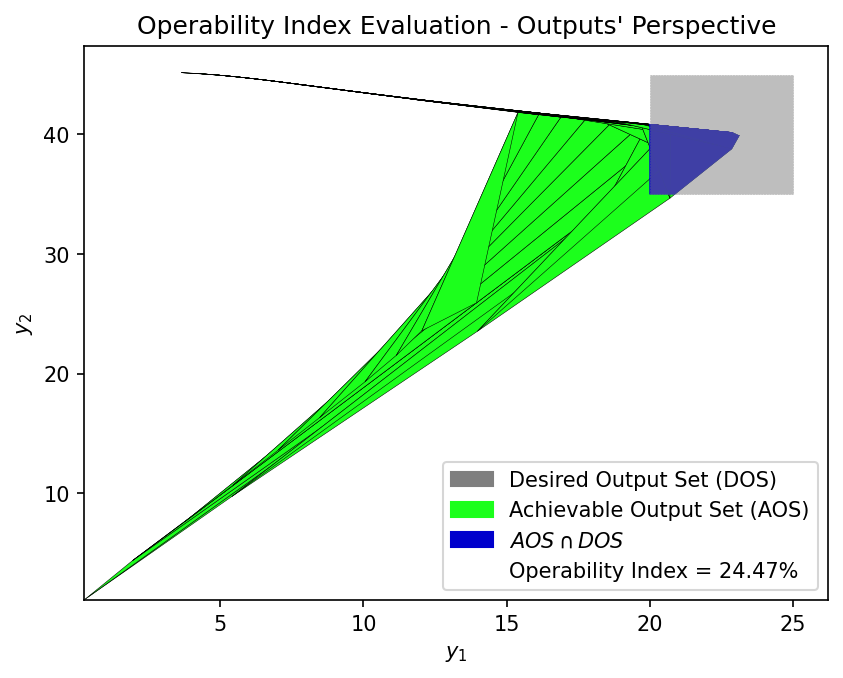

In [14]:
OI_surr = OI_eval(AOS_surr, DOS_bounds, plot=True)

In [15]:
# OI Comparison Summary
print("\n" + "=" * 60)
print("OPERABILITY INDEX COMPARISON")
print("=" * 60)
print(f"\n  {'Metric':<25} {'First-Principles':>18} {'GP Surrogate':>18}")
print(f"  {'-'*25} {'-'*18} {'-'*18}")
print(f"  {'OI Value':<25} {OI_fp:>17.2f}% {OI_surr:>17.2f}%")
print(f"  {'Multimodel Time [s]':<25} {time_fp_mm:>18.2f} {time_surr_mm:>18.2f}")
print(f"\n  Relative Error in OI: {abs(OI_fp - OI_surr) / OI_fp * 100:.2f}%")
print(f"  Speedup: {time_fp_mm/time_surr_mm:.1f}x faster")


OPERABILITY INDEX COMPARISON

  Metric                      First-Principles       GP Surrogate
  ------------------------- ------------------ ------------------
  OI Value                              23.95%             24.47%
  Multimodel Time [s]                     4.15               1.51

  Relative Error in OI: 2.15%
  Speedup: 2.7x faster


### Conclusions

This example demonstrates that validated GP surrogates can reliably replace computationally expensive first-principles models for operability analysis.

**Key Results:**
- **Surrogate Accuracy:** R² > 0.999 on the holdout test set
- **Inverse Mapping:** <1% relative error compared to first-principles, with ~4x speedup
- **Operability Index:** ~2% relative error compared to ground truth (OI values are also sensitive to the discretization resolution used)

**Workflow Summary:**
1. Generate training data from the rigorous model using Latin Hypercube Sampling
2. Train and validate GP models for each output
3. (Optional) Deploy as a JAX function for automatic differentiation
4. Use `opyrability` functions with the surrogate

The surrogate training is a one-time cost that enables rapid exploration of different DOS specifications or constraint scenarios.